# ICP: standard algorithm for obtain rigid body transform in practice

## Vanilla ICP based on SVD

### 1) ICP precursor - point clouds with corresponding points



#### a) Formal Problem Definition

- Let, $a_i$ be a point $i$ of set $a$ (with $n_a$ points), and $b_i$ a point $i$ on set $b$ (with $n_b$ points), homologous with $a_i$;

- We wish to find $R$ and $t$ of the rigid body transform: $a^{new}_i = Ra_i +t$;

- That minimizes the error function:

$$
e = \sum|| Ra_i +t - b_i||^2 = min  \ \ \ \ \ \ \ \ (1)
$$



#### b) Direct Optimal Solution

A solution to equation (1) with no initial guess and better than anyother is:

- Shift all poits to be centered in its center of mass;

- Perform a rotational alingment using Singular Value Decomposition (SVD).

In math terms, first we do a centroid calculation:

$$
\overline{a} = \frac{1}{n_a}\sum a_i \\
\overline{b} = \frac{1}{n_b}\sum b_i
$$

Do the shift:

$$
a'_i = a_i - \overline{a}  \\
b'_i = b_i - \overline{b}
$$

Compute Cross covariance matrix $H$:

$$
H = \sum a'_i{b'}^T_i
$$

Do a SVD on $H$:

$$
U\Sigma V^T = H
$$

The optimal $R$ ([proof here](https://youtu.be/dhzLQfDBx2Q?si=FDIqaFbgLxZkiamq&t=2516)) is found to be:

$$
R = VU^T
$$

Then, optimal $t$ is:

$$
t = \overline{b} - R\overline{a}
$$


### 2) ICP without corresponding points





#### a) Formal Problem Definition

- Let, $a$ be a point $i$ of set $a$ (with $n_a$ points), and $b_k$ a point $k$ on set $b$ (with $n_b$ points);

- We have a initial guess or some N point correspondeces;

- We wish to iteratively find the association $a_i$-$b_i$ and the transformation $R$ and $t$ of the rigid body transform: $a^{new}_i = Ra_i +t$;

- That minimizes the error function:

$$
e = \sum|| Ra_i +t - b_i||^2 = min  \ \ \ \ \ \ \ \ (1)
$$


#### b) Iterative Solution

- Pick for every point its closest neighnoor in the other point cloud;

- Compute the rigid body trasnform and align using SVD;

- Repeat till convergence.

In math terms, first we do a centroid calculation:

$$
\overline{a} = \frac{1}{n_a}\sum a_i \\
\overline{b} = \frac{1}{n_b}\sum b_i
$$

Do the shift:

$$
a'_i = a_i - \overline{a} \\
b'_i = b_i - \overline{b}
$$

Compute correspondences with nearest neighboor:

```python
correspondences = []
for k in range(n_b):
  distmin = 1000000000
  for i in range(n_a):
    dist = np.linalg.norm(a[i]-b[k])
    if dist<distmin:
      distmin = dist
      idx = i
  correspondences.append( (k,idx,distmin) )
```

Compute Cross covariance matrix $H$:

$$
H = \sum a'_i {b'}^T_i
$$

Do a SVD on $H$:

$$
U\Sigma V^T = H
$$

The optimal $R$ is found to be:

$$
R^{new} = VU^T
$$

Then, optimal $t$ is:

$$
t^{new} = \overline{b} - R^{new}\overline{a}
$$

If it's not the first iteration, remember to stack the transformations:

$$
R = R \cdot R^{new} \\
t = t+t^{new} \\
$$

Update $a$ in this iteration:

$$
a^{new}_i =  R{a_i} + t
$$

Recenter this new $a$:

$$
a'_i = a^{new}_i - \overline{a} \\
$$

Compute error:

$$
error = || a' - b' ||
$$

If error do not reach the tolerance, repeat 1st step.


### 3) Problems with the Vanilla ICP


- May require many iterations;
- Bad correspondentes degrade the results or stop them at local minima.



### 4) ICP variants


- Non linear Least squares based ICP
- Using point to plane metric with Least Squares ICP
- Different data associations strategies
- Weight the correspondences, i.e:

Distant points will have less importance and the mean becames weighted mean.

| b   | closest a | distance |  weight function (w) | normalized weight(p) |
| --- | --------- |--------- | -------     | -------------------- |
| 1   | 2         | 320      | 1/320       |  (1/320)/$\sum w_i$  |
| 2   | 2         | 227      | 1/227       |  (1/227)/$\sum w_i$  |
| 3   | 2         | 120      | 1/120       |  (1/120)/$\sum w_i$  |
| 4   | 7         | 310      | 1/310       |  (1/310)/$\sum w_i$  |
| 5   | 9         | 287      | 1/287       |  (1/287)/$\sum w_i$  |
| ... | ...       | ...      | ...         |  ...|
| n_b | i         | distmin  | 1/distmin   |  (1/distmin)/$\sum w_i$  |

$$
\overline{a} = \frac{\sum a_ip_i}{\sum p_i} \\
\overline{b} = \frac{\sum b_ip_i}{\sum p_i} \\
H = \sum a'_i {b'}^T_i p_i
$$

- remove outliers, i.e:

 Find and remove higher distances => Small but good number of matched data  => less computation with almost the same results.

| b   | closest a | distance |  remove  ? |
| --- | --------- |--------- | --------- |
| 1   | 2         | 320      | yes |
| 2   | 2         | 227      | yes |
| 3   | 2         | 120      | no |
| 4   | 7         | 310      | |
| 5   | 9         | 287      | |
| ... | ...       | ...      | |
| n_b | i         | distmin  | |

Also we could remove $t%$ of the higher distances. $t$ can be adaptative. Sometimes 10%, 20% or 50% dependig on situation. For example, if we have moving objetct between LiDAR point clouds, we will want for find and remove  these object points in correspondece or give to it less weight.


## Easy dataset

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
from sklearn.neighbors import KDTree

!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-11-15 17:30:16 -03:00)


### Functions

In [3]:
def nearest_neighbor(P, Q, good_guess=()):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        List:
          indices of point cloud P
          indices of mathced point cloud Q
          distance
    '''
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in tqdm(range(p_size)):
      if good_guess and i == good_guess[0]:
        correspondences.append(good_guess)
      else:
        p_point = P[:, i]
        min_dist = 1000000
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx, min_dist))
    return correspondences

def kdtree_nearest_neighbor(P, Q):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src by KDTree search (faster)
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        List:
          indices of point cloud P
          indices of mathced point cloud Q
          distance
    '''
    tree = KDTree(Q.T)
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        nearest_dist, nearest_ind = tree.query([p_point], k=2)  # k=2 nearest neighbors where k1 = identity
        d = nearest_dist[:,1][0]
        j = nearest_ind[:,1][0]
        correspondences.append((i, j, d))
    return correspondences

# Transform parameters
def Rpry(pitch, roll, yaw):
    # Single rotation matrix combining pitch, roll, yaw --> sim, talvez, não
    return np.array([[np.cos(yaw)*np.cos(pitch), np.cos(yaw)*np.sin(pitch)*np.sin(roll) - np.sin(yaw)*np.cos(roll), np.cos(yaw)*np.sin(pitch)*np.cos(roll) + np.sin(yaw)*np.sin(roll)],
                    [np.sin(yaw)*np.cos(pitch), np.sin(yaw)*np.sin(pitch)*np.sin(roll) + np.cos(yaw)*np.cos(roll), np.sin(yaw)*np.sin(pitch)*np.cos(roll) - np.cos(yaw)*np.sin(roll)],
                    [-np.sin(pitch), np.cos(pitch) * np.sin(roll), np.cos(pitch) * np.cos(roll)] ])

# plot functions
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8,title=""):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    ax.set_title(title)
    return ax

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j, d in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

def plotar_3d(x1,y1,z1,x2=[],y2=[],z2=[]):
  ax = plt.figure().add_subplot(projection='3d')
  ax.scatter(xs=x1, ys=y1, zs=z1, facecolor=(1,0,0,.4), edgecolor=(1,0,0,.1))
  if len(x2)==len(y2) and len(y2)==len(z2) and len(x2)>0:
    ax.scatter(xs=x2, ys=y2, zs=z2, facecolor=(0,0,1,.4), edgecolor=(0,0,1,.14))
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  return ax

time: 0 ns (started: 2024-11-15 17:30:16 -03:00)


### Execution

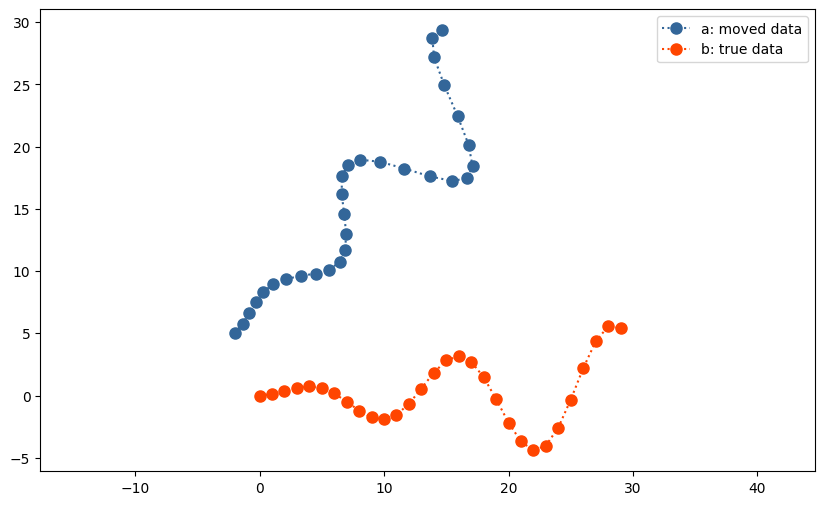

time: 110 ms (started: 2024-11-15 17:30:16 -03:00)


In [4]:
# initialize pertrubation rotation
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)],
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :])
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
b = true_data
a = moved_data

plot_data(moved_data, true_data, "a: moved data", "b: true data")
plt.show()

(2, 30) 
 (2, 30)


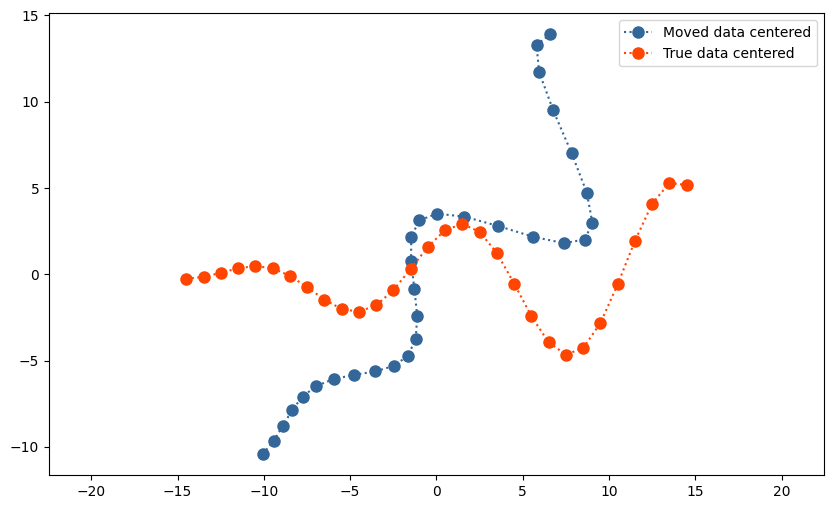

time: 125 ms (started: 2024-11-15 17:30:16 -03:00)


In [5]:
# shift point clouds to its centroid
a_center = a.mean(axis=1).reshape((2,1))
b_center = b.mean(axis=1).reshape((2,1))
a_centered = a - a_center
b_centered = b - b_center
print(a_centered.shape,'\n',b_centered.shape)
ax = plot_data(a_centered, b_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

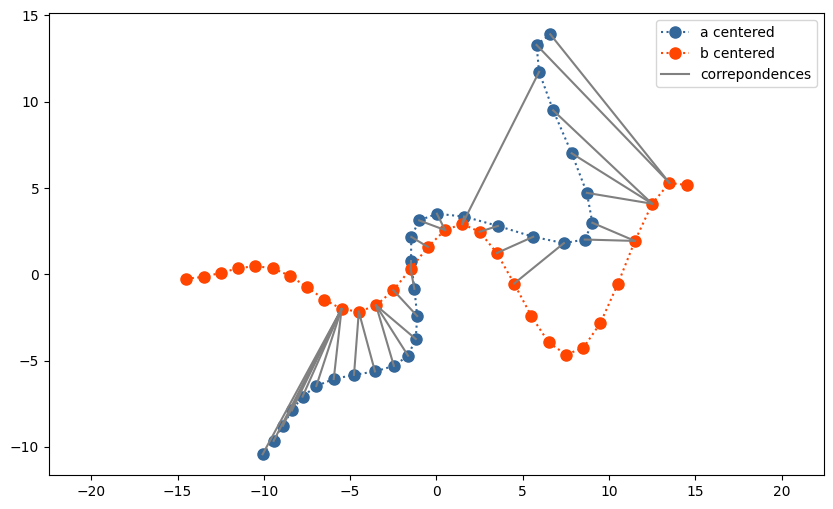

time: 172 ms (started: 2024-11-15 17:30:17 -03:00)


In [6]:
# compute correspondeces with nearest neighboor
correspondences = nearest_neighbor(a_centered, b_centered)

ax = plot_data(a_centered, b_centered,
               label_1='a centered',
               label_2='b centered')
draw_correspondeces(a_centered, b_centered, correspondences, ax)
plt.show()

correspondences:
[(0, 9, 9.583370382167361),
 (1, 9, 8.599378309546077),
 (2, 9, 7.573984961243393),
 (3, 9, 6.542684363175932),
 (4, 9, 5.558516737089527),
 (5, 9, 4.695487736508346),
 (6, 9, 4.083061973288728),
 (7, 10, 3.670059281129938),
 (8, 10, 3.585859606218316),
 (9, 11, 3.6564739649822173),
 (10, 11, 3.45106635264372),
 (11, 11, 3.0131153506348674),
 (12, 12, 2.039075804902581),
 (13, 13, 1.172174460915771),
 (14, 13, 0.46173560221657767),
 (15, 14, 1.1195193063947346),
 (16, 15, 1.6016550206015505),
 (17, 15, 1.059223234895558),
 (18, 16, 0.44335097233871507),
 (19, 17, 1.1135164215140834),
 (20, 18, 2.305104512966225),
 (21, 19, 3.7167654968831574),
 (22, 26, 2.9096575771243636),
 (23, 26, 2.679895488977418),
 (24, 27, 3.8363261417472883),
 (25, 27, 5.504229218740353),
 (26, 27, 7.884657660443491),
 (27, 16, 9.873303227548387),
 (28, 28, 11.09941305882456),
 (29, 28, 11.038783982629349)]

new_correspondences:
[(6, 9, 4.083061973288728),
 (8, 10, 3.585859606218316),
 (11, 11,

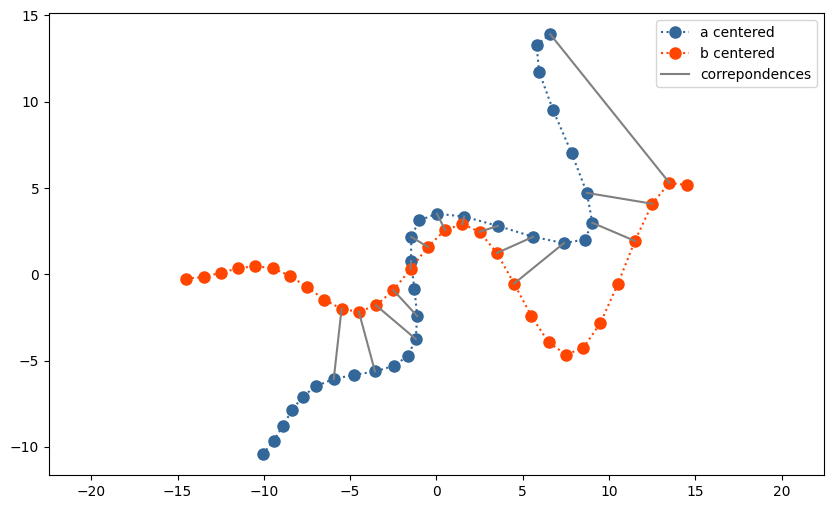

time: 203 ms (started: 2024-11-15 17:30:17 -03:00)


In [7]:
# (OPTIONALY) remove larger distances from the correspondences
print('correspondences:')
pprint(correspondences)

js = list(set([j for i, j, d in correspondences]))
grouped_correspondences = {}
for i, j, d in correspondences:
  if not j in grouped_correspondences:
    grouped_correspondences[j] = [(i, d)]
  else:
    grouped_correspondences[j].append((i, d))

new_correspondences = []
for k in grouped_correspondences:
  dmin = 100000000
  for c in grouped_correspondences[k]:
    if c[1]<dmin:
      dmin = c[1]
      idx = c[0]
  new_correspondences.append((idx, k, dmin))

print('\nnew_correspondences:')
pprint(new_correspondences)

ax = plot_data(a_centered, b_centered,
               label_1='a centered',
               label_2='b centered')
draw_correspondeces(a_centered, b_centered, new_correspondences, ax)
plt.show()

In [8]:
# compute cross covariance matrix
H = np.zeros((2,2))
for i, j,d  in correspondences:
  a_point = a_centered[:, [i]]
  b_point = b_centered[:, [j]]
  # H += np.outer(a_point,b_point)
  H += b_point.dot(a_point.T)
print(H)

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]
time: 0 ns (started: 2024-11-15 17:30:17 -03:00)


In [9]:
# SVD  decomposition
U, S, V_T = np.linalg.svd(H)
print(S)
R_found = U.dot(V_T)
t_found = b_center - R_found.dot(a_center)
print("R_found =\n", R_found)
print("t_found =\n", t_found)
R = R_found.copy()
t = t_found.copy()

[1712.35558954   63.95608054]
R_found =
 [[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
t_found =
 [[  0.4278782 ]
 [-10.01055887]]
time: 0 ns (started: 2024-11-15 17:30:17 -03:00)


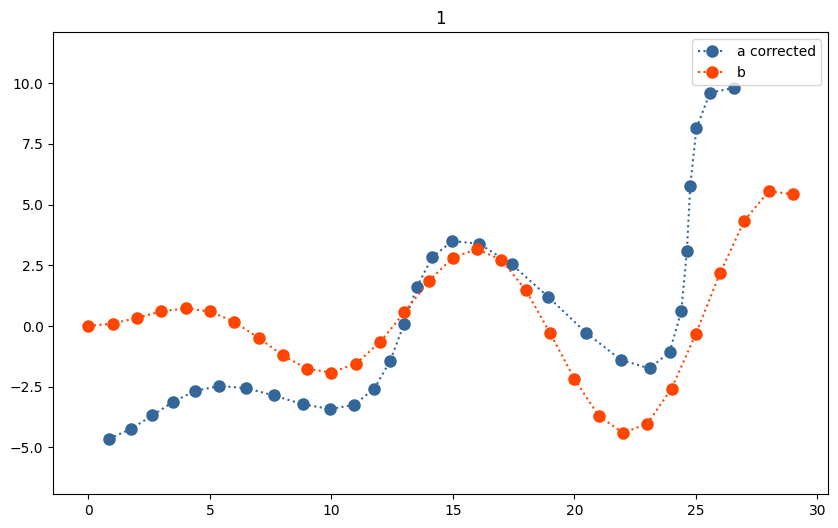

Squared diff: (a_corrected - b) =  16.052894296516946
time: 109 ms (started: 2024-11-15 17:30:17 -03:00)


In [10]:
# Apply correction
a_corrected = R_found.dot(a) + t_found
ax = plot_data(a_corrected, b, label_1='a corrected', label_2='b', title=f"{1}")
plt.show()
print("Squared diff: (a_corrected - b) = ", np.linalg.norm(a_corrected - b))

In [11]:
errors = []
iteration=1

time: 0 ns (started: 2024-11-15 17:30:17 -03:00)


  0%|          | 0/30 [00:00<?, ?it/s]

Error: 25.698521314536677


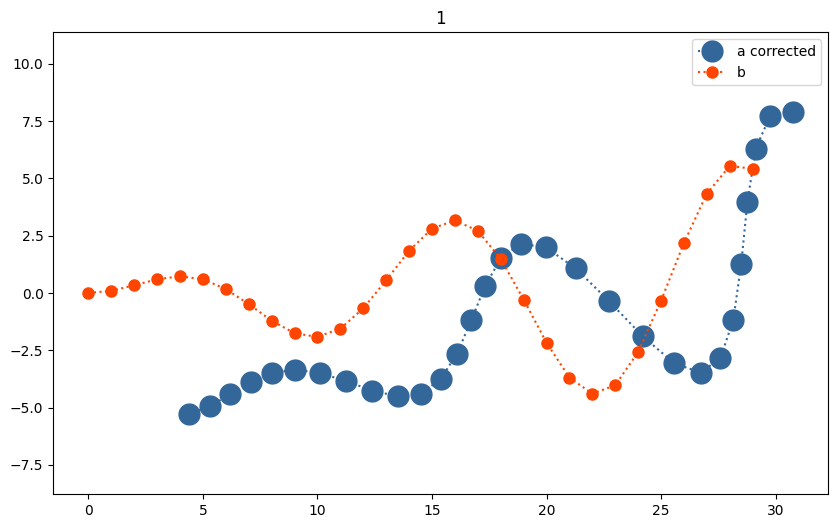

  0%|          | 0/30 [00:00<?, ?it/s]

Error: 12.80113614169714


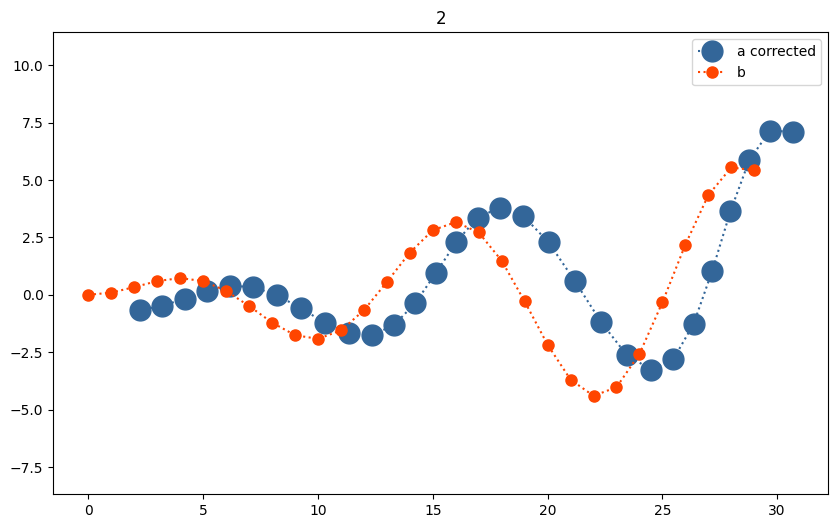

  0%|          | 0/30 [00:00<?, ?it/s]

Error: 2.412980258164563


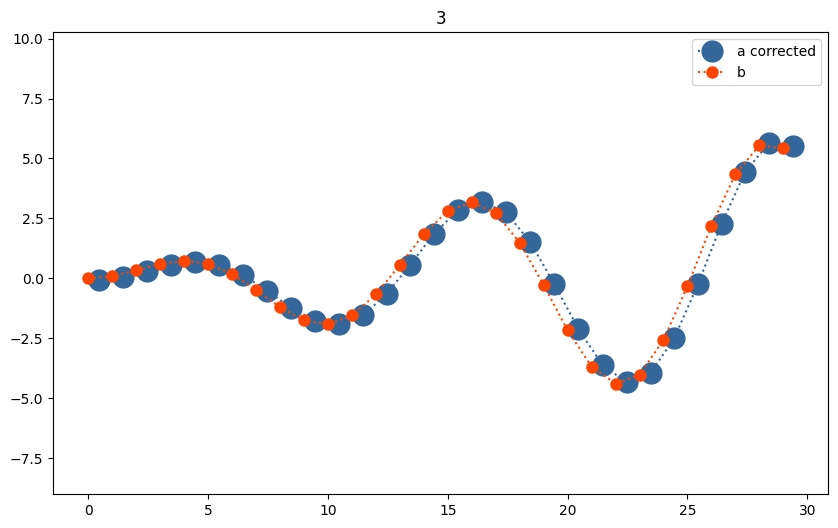

  0%|          | 0/30 [00:00<?, ?it/s]

Error: 0.17238994644910002


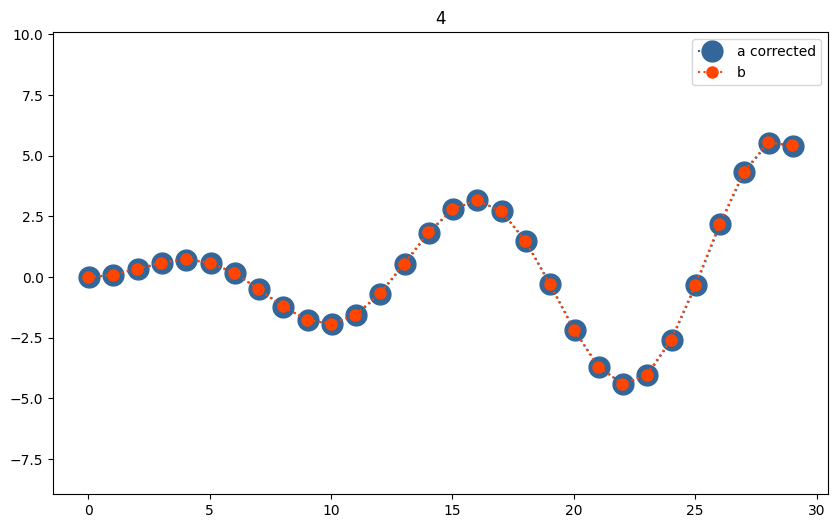

  0%|          | 0/30 [00:00<?, ?it/s]

Error: 3.9188454893124155e-14


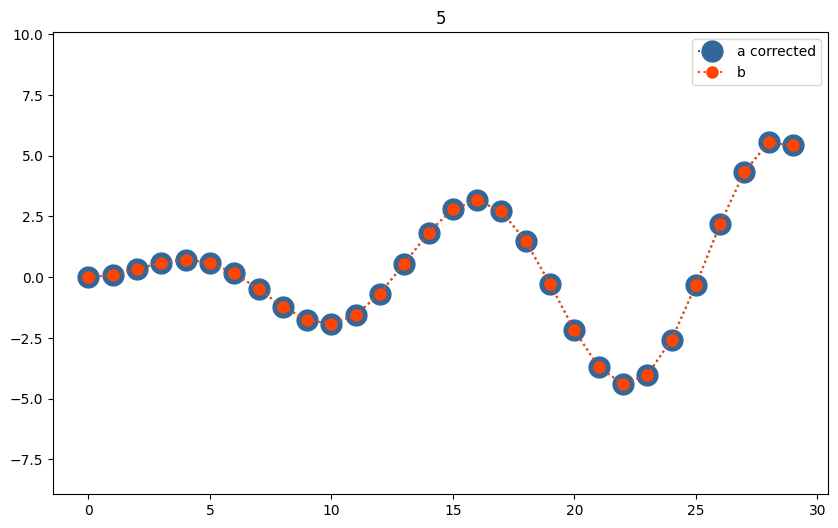

  0%|          | 0/30 [00:00<?, ?it/s]

Error: 4.865787522555813e-14


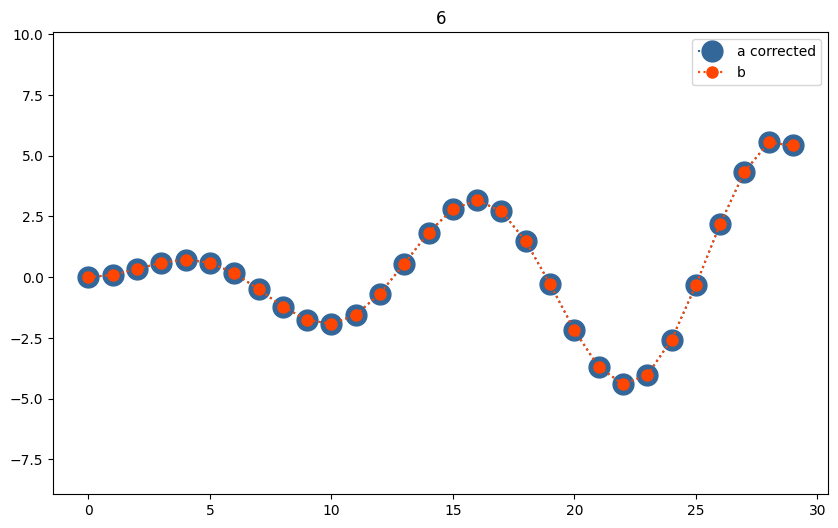

time: 1.17 s (started: 2024-11-15 17:31:23 -03:00)


In [21]:
######### Make next iterations - play this cell many times needed
for iteration in range(1,7):
  # shift point clouds to its centroid
  a_center = a_corrected.mean(axis=1).reshape((2,1))
  a_centered = a_corrected - a_center
  # compute correspondeces with nearest neighboor
  correspondences = nearest_neighbor(a_centered, b_centered)
  # compute cross covariance matrix
  H = np.zeros((2,2))
  for i, j,d  in correspondences:
    a_point = a_centered[:, [i]]
    b_point = b_centered[:, [j]]
    H += b_point.dot(a_point.T)
  # SVD decomposition
  U, S, V_T = np.linalg.svd(H)
  R_found = U.dot(V_T)
  t_found = b_center - R_found.dot(a_center)
  # stack transformations
  R = R_found.dot(R)
  t = t+t_found
  # Apply correction
  # a_corrected = R_found.dot(a_corrected) + t_found
  # or
  a_corrected = R.dot(a) + t
  # get last erros
  error = np.linalg.norm(a_corrected - b)
  print("Error:", error)
  errors.append(error)

  plot_data(a_corrected, b, label_1='a corrected', label_2='b',markersize_1=15,title=f"{iteration}")
  plt.show()

In [22]:
R_true, t_true, R, t

(array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]),
 array([[-2],
        [ 5]]),
 array([[ 0.70710678,  0.70710678],
        [-0.70710678,  0.70710678]]),
 array([[-2.12132034],
        [-4.94974747]]))

time: 0 ns (started: 2024-11-15 17:31:41 -03:00)


### Outlier injection on point cloud

In [23]:
# Outlier injection
a_bad = moved_data.copy()
b = true_data.copy()
print("a[10] and a[20] original values",a[:,10],a[:,20])
a_bad[:, 10] = np.array([-10, 30])
a_bad[:, 20] = np.array([0, 40])
print("a[10] and a[20] outlierized values",a_bad[:,10],a_bad[:,20])

a[10] and a[20] original values [ 6.42719153 10.7149441 ] [13.68085969 17.60341156]
a[10] and a[20] outlierized values [-10.  30.] [ 0. 40.]
time: 0 ns (started: 2024-11-15 17:31:52 -03:00)


In [24]:
# initializations
a_corrected = a_bad.copy()
b_center = b.mean(axis=1).reshape((b.shape[0],1))
b_centered = b - b_center

R = np.eye(2)
t = np.zeros((b.shape[0],1))
iteration = 0
error = np.linalg.norm(a_corrected - b)
errors = []
exclude_indices = [] # <<--- for removing outliers
threshold = 1 # <<--- for removing outliers, can be adaptative
print(f"Iteration {iteration} error: {error}")

Iteration 0 error: 112.11909435083369
time: 0 ns (started: 2024-11-15 17:31:55 -03:00)


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 1 error: 41.921093356811056
Iteration 1 ||I-R||: 0.46648520398936305 ||t||: 13.55671049844146


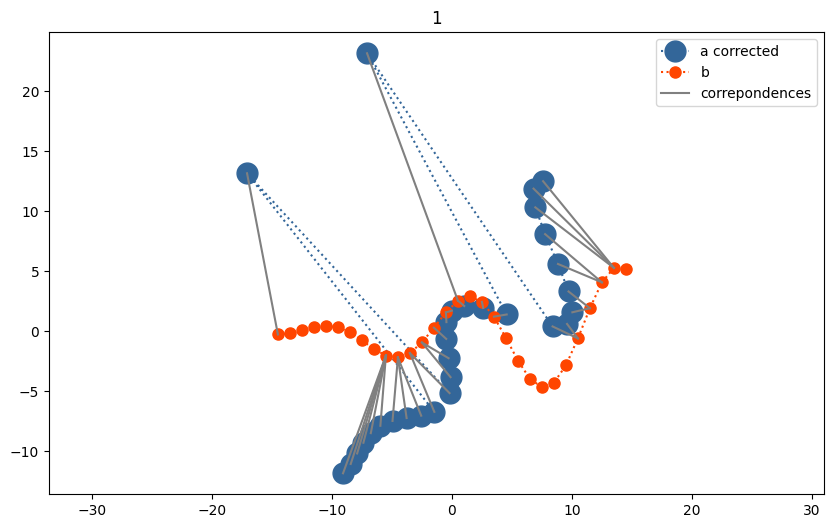

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 2 error: 40.66647933287497
Iteration 2 ||I-R||: 0.3064646688023921 ||t||: 3.142664790277814


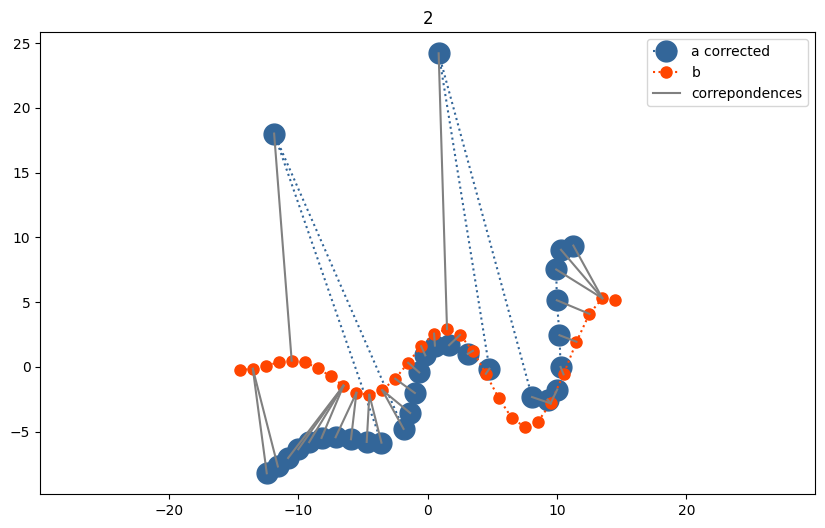

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 3 error: 39.26739541114459
Iteration 3 ||I-R||: 0.42100505945234795 ||t||: 5.463051787034761


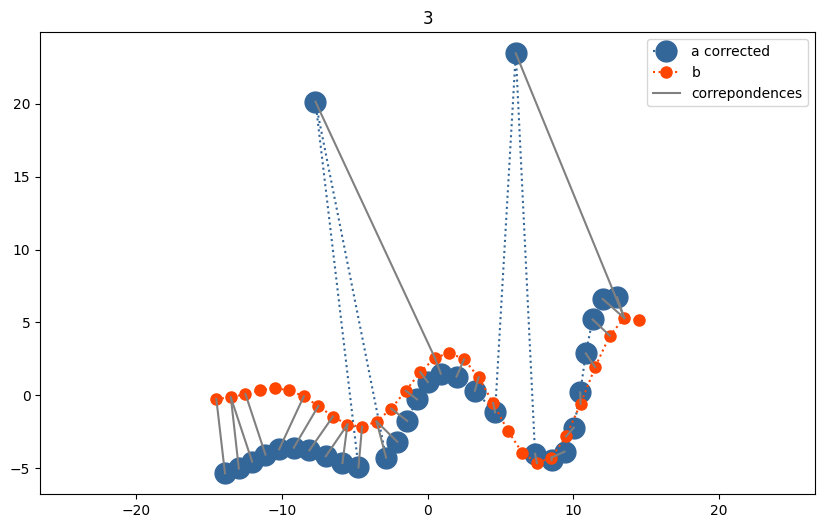

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 4 error: 35.89983382133666
Iteration 4 ||I-R||: 0.12651852745652994 ||t||: 3.3512605836029343


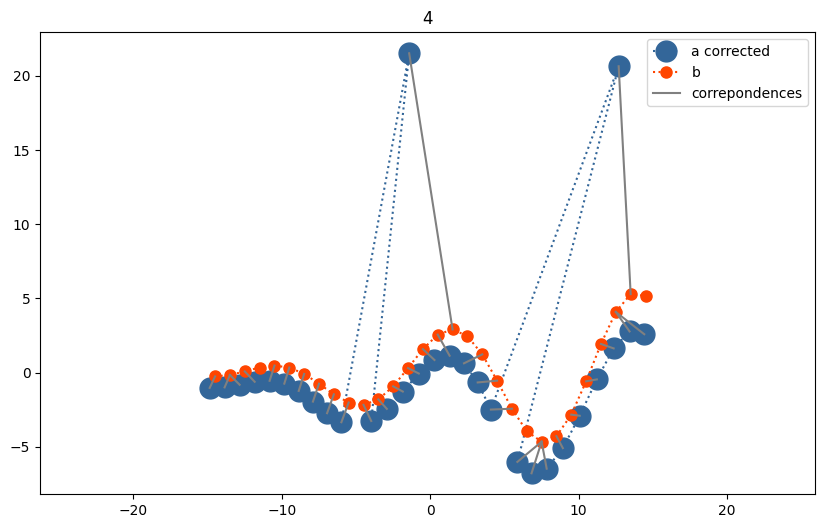

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 5 error: 36.09401457701451
Iteration 5 ||I-R||: 0.041471326365322324 ||t||: 0.6391503320706831


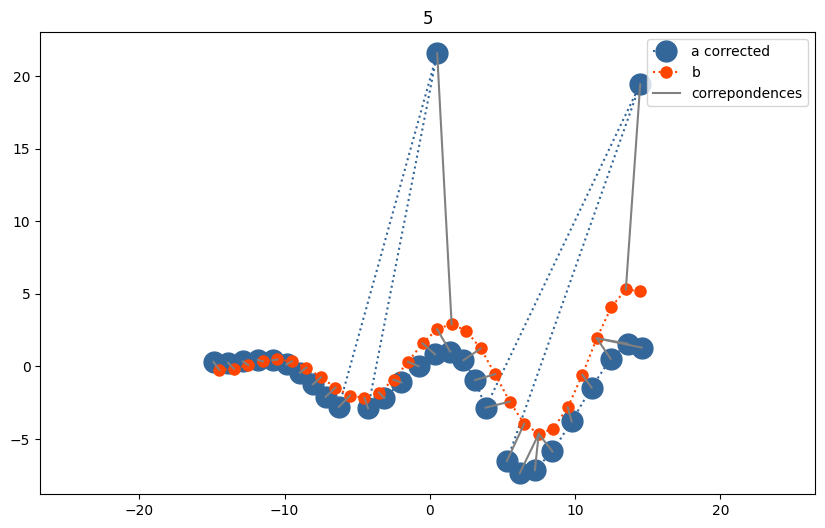

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 6 error: 36.16833936962947
Iteration 6 ||I-R||: 0.010920528213951078 ||t||: 0.22813357535860176


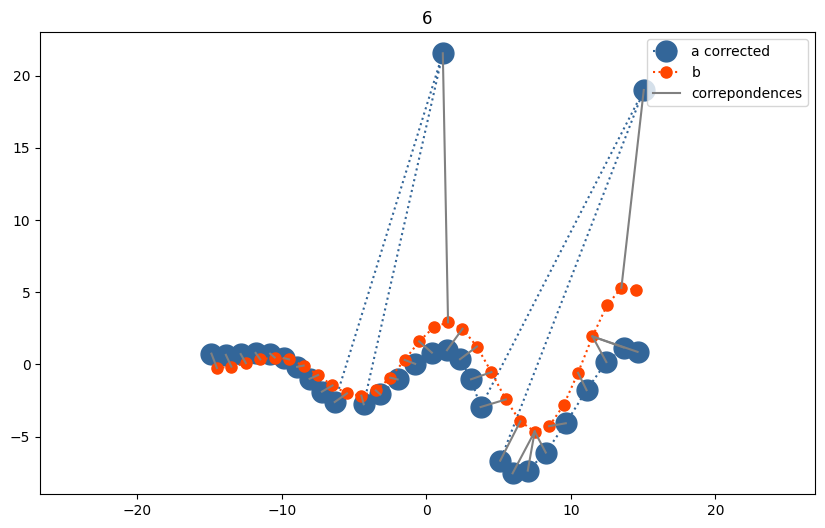

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 7 error: 36.30431977306389
Iteration 7 ||I-R||: 0.017003022932035403 ||t||: 0.20193221032177766


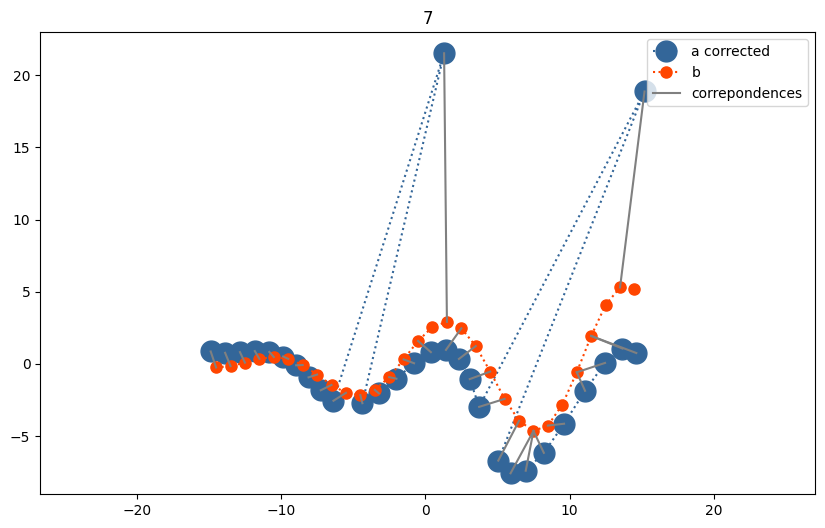

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 8 error: 36.30296364950159
Iteration 8 ||I-R||: 3.103766229860222e-16 ||t||: 0.05729003631911676


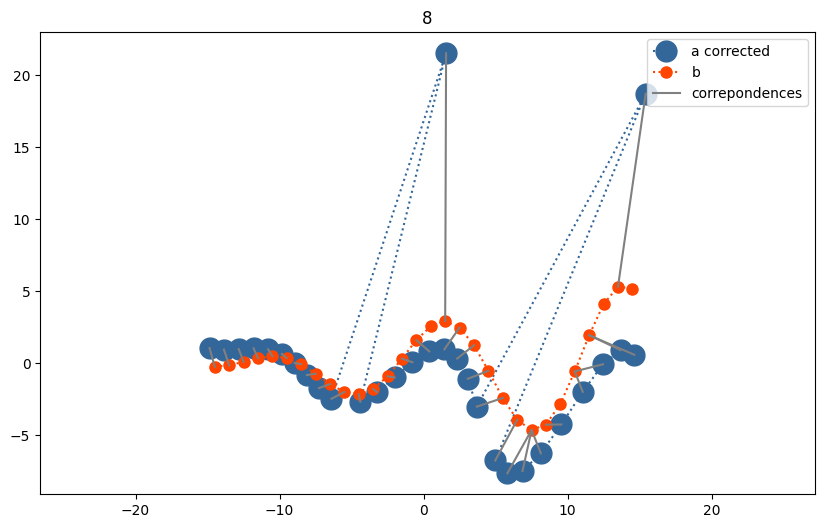

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 9 error: 36.3029636495016
Iteration 9 ||I-R||: 2.543496323945741e-16 ||t||: 1.897149936107019e-15


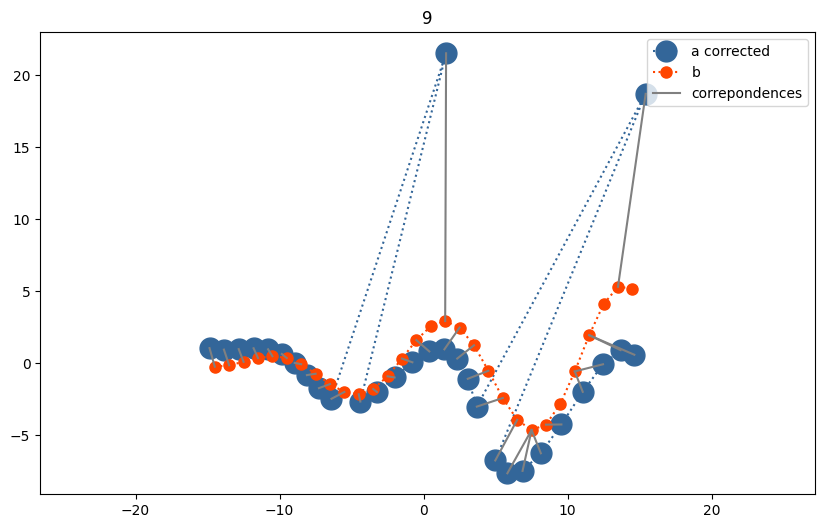

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 10 error: 36.30296364950159
Iteration 10 ||I-R||: 2.6174693485960674e-16 ||t||: 5.329070518200751e-15


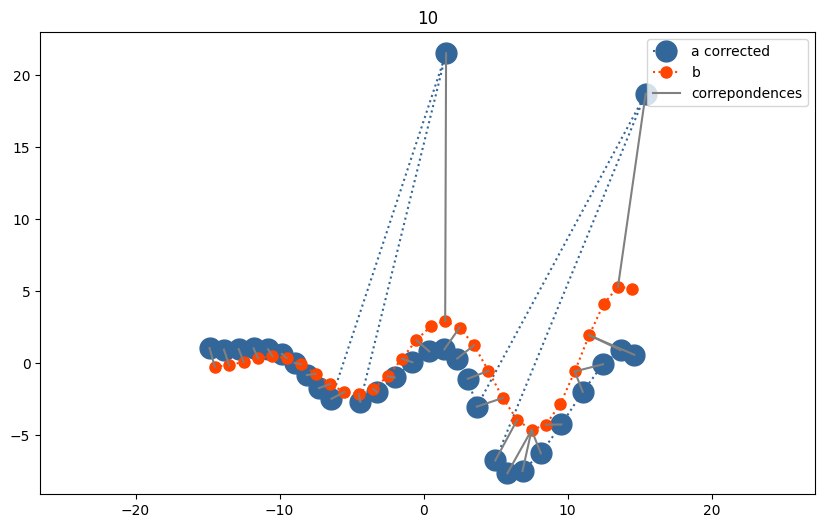

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 11 error: 36.302963649501585
Iteration 11 ||I-R||: 2.503138313698455e-16 ||t||: 3.614624287906422e-15


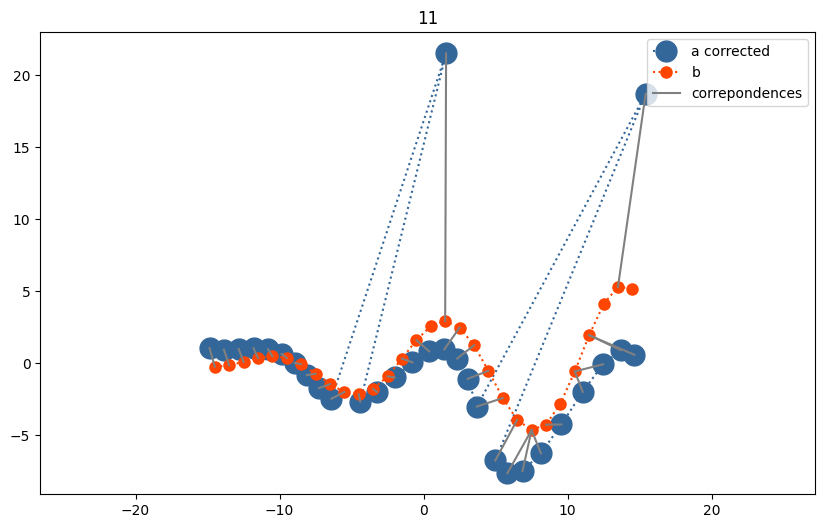

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 12 error: 36.302963649501585
Iteration 12 ||I-R||: 2.499742657118071e-16 ||t||: 3.5566146649215975e-15


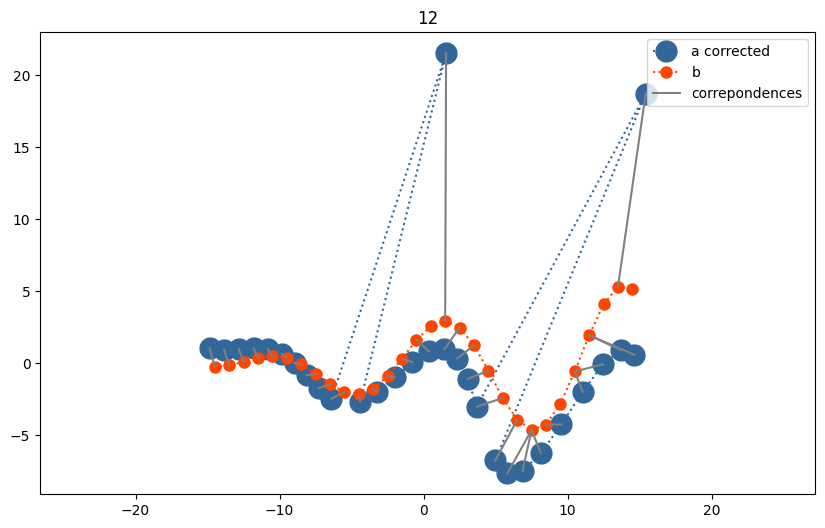

  0%|          | 0/30 [00:00<?, ?it/s]

Iteration 13 error: 36.302963649501585
Iteration 13 ||I-R||: 4.630591449227609e-17 ||t||: 1.1102230246251565e-16


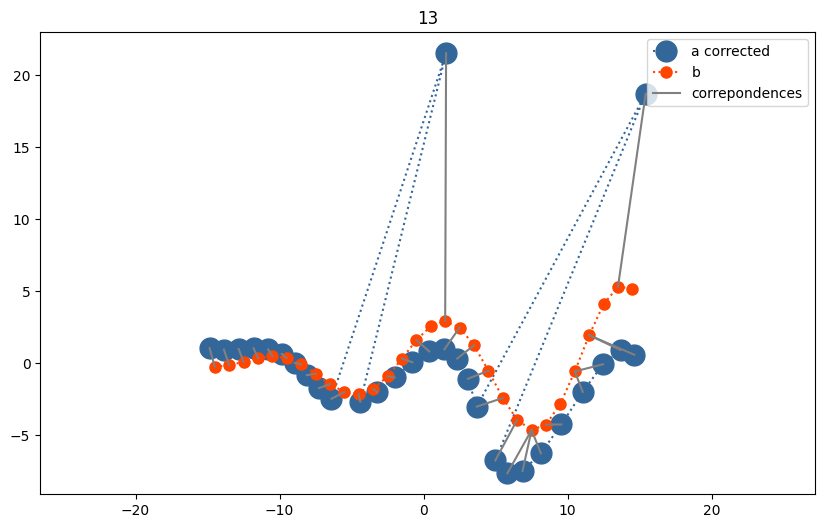

time: 2.58 s (started: 2024-11-15 17:32:34 -03:00)


In [25]:
######### Make next iterations
for iteration in range(1,14):
  # shift point clouds to its centroid
  # reduced_data = np.delete(a_corrected, exclude_indices, axis=1)
  a_center = a_corrected.mean(axis=1).reshape((b.shape[0],1))
  a_centered = a_corrected - a_center
  # compute correspondeces with nearest neighboor
  correspondences = nearest_neighbor(a_centered, b_centered)
  # compute cross covariance matrix
  exclude_indices = []
  norms = [] # (A*)
  H = np.zeros((b.shape[0],b.shape[0]))
  for i, j, d in correspondences:
    a_point = a_centered[:, [i]]
    b_point = b_centered[:, [j]]
    H += b_point.dot(a_point.T)
  # SVD decomposition
  U, S, V_T = np.linalg.svd(H)
  R_found = U.dot(V_T)
  t_found = b_center - R_found.dot(a_center)
  # stack transformations
  R = R_found.dot(R)
  t = t+t_found
  # Apply correction
  # a_corrected = R_found.dot(a_corrected) + t_found
  # or
  a_corrected = R.dot(a_bad) + t
  # get last erros
  error = np.linalg.norm(a_corrected - b)
  print(f"Iteration {iteration} error: {error}")
  print(f"Iteration {iteration} ||I-R||: {np.linalg.norm(np.eye(2)-R_found)} ||t||: {np.linalg.norm(t_found)}")
  errors.append(error)

  ax = plot_data(a_centered, b_centered, label_1='a corrected', label_2='b',markersize_1=15,title=f"{iteration}")
  draw_correspondeces(a_centered, b_centered, correspondences, ax)
  plt.show()

Notice that it never gets better!

### Solution - weight and remove bad correspondences

In [26]:
# initializations
a_corrected = a_bad.copy()
a_center = a_corrected.mean(axis=1).reshape((b.shape[0],1))
a_centered = a_corrected - a_center
b_center = b.mean(axis=1).reshape((b.shape[0],1))
b_centered = b - b_center

R = np.eye(2)
t = np.zeros((b.shape[0],1))
iteration = 0
error = np.linalg.norm(a_centered - b_centered)
errors = []
errors2 = []
exclude_a_indices = []
threshold = 0.1 # <<--- for removing outliers, can be adaptative
print(f"Iteration {iteration} error: {error}")

Iteration 0 error: 51.76451406494949
time: 0 ns (started: 2024-11-15 17:33:07 -03:00)


  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 1 ||a_centered - b_centered||: 44.5778274914632
Iteration 1 ||I-R||: 0.36028308979022644 ||t||: 5.074678218612856 sum: 5.434961308403083


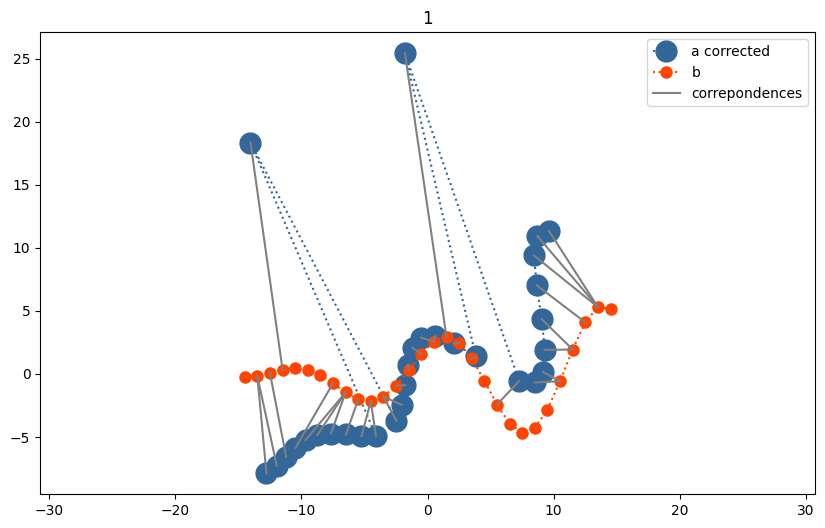

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 2 ||a_centered - b_centered||: 38.82812246424843
Iteration 2 ||I-R||: 0.18207559363843104 ||t||: 2.0496995336434494 sum: 2.2317751272818804


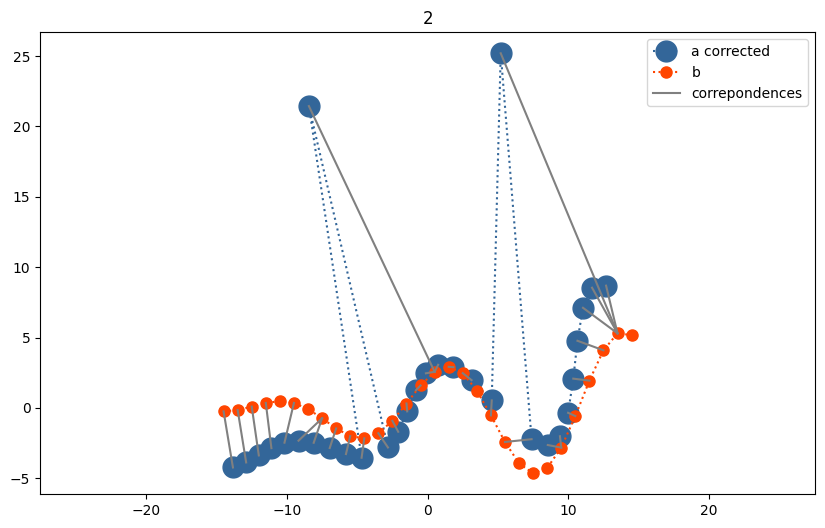

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 3 ||a_centered - b_centered||: 37.06432571741969
Iteration 3 ||I-R||: 0.12039380530090023 ||t||: 1.2345872506780395 sum: 1.3549810559789397


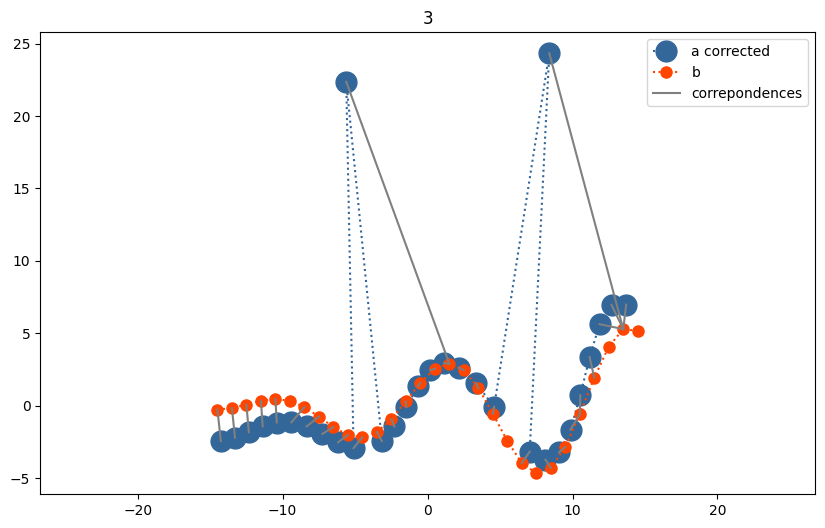

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 4 ||a_centered - b_centered||: 36.43205676580487
Iteration 4 ||I-R||: 0.06620161078425592 ||t||: 0.678869352491353 sum: 0.745070963275609


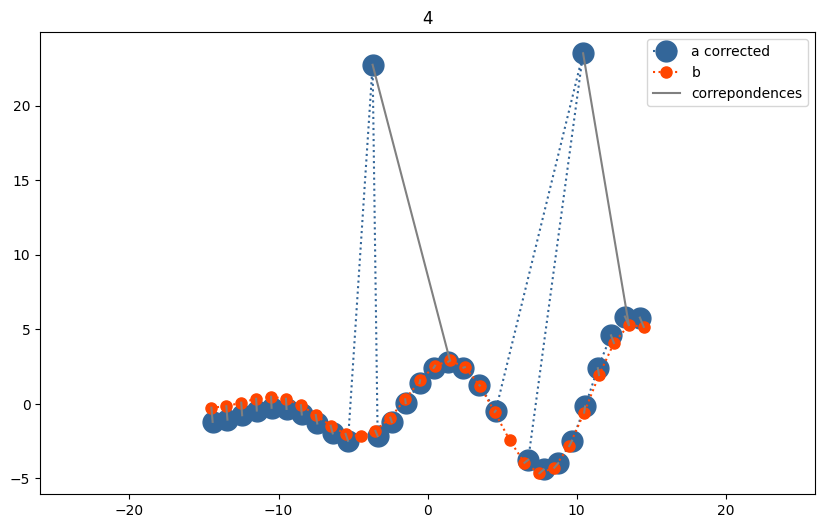

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 5 ||a_centered - b_centered||: 36.27894969438916
Iteration 5 ||I-R||: 0.0010631878316571006 ||t||: 0.010902538870329253 sum: 0.011965726701986354


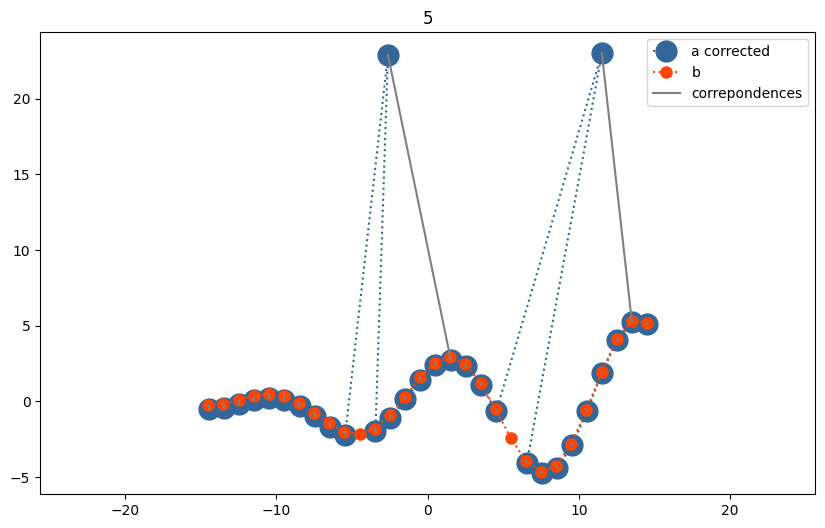

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 6 ||a_centered - b_centered||: 36.27763935330488
Iteration 6 ||I-R||: 0.0009638780754089585 ||t||: 0.009884159572279144 sum: 0.010848037647688102


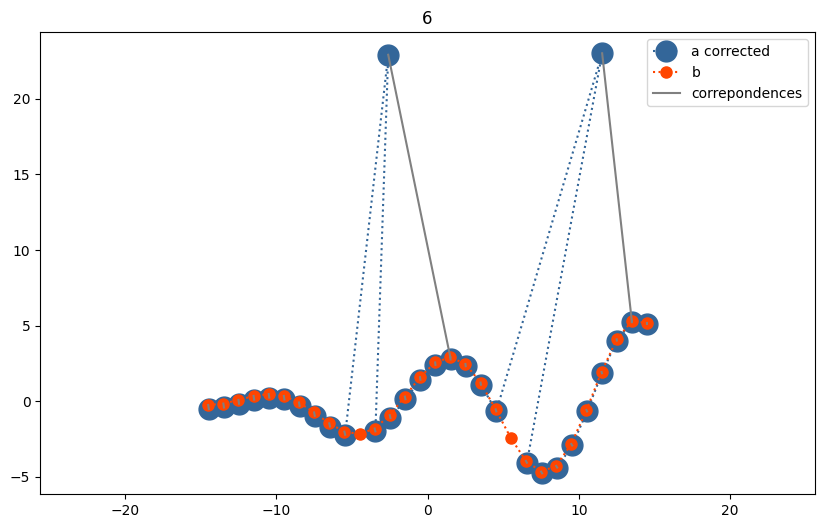

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 7 ||a_centered - b_centered||: 36.27648290098333
Iteration 7 ||I-R||: 0.0008712977403486276 ||t||: 0.008934787625414189 sum: 0.009806085365762817


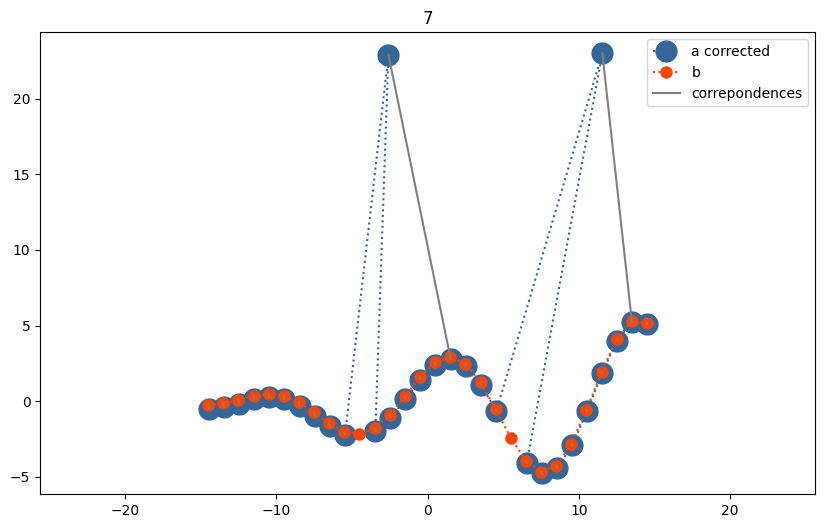

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 8 ||a_centered - b_centered||: 36.275463301883214
Iteration 8 ||I-R||: 0.0007854248384317475 ||t||: 0.008054197551694162 sum: 0.008839622390125909


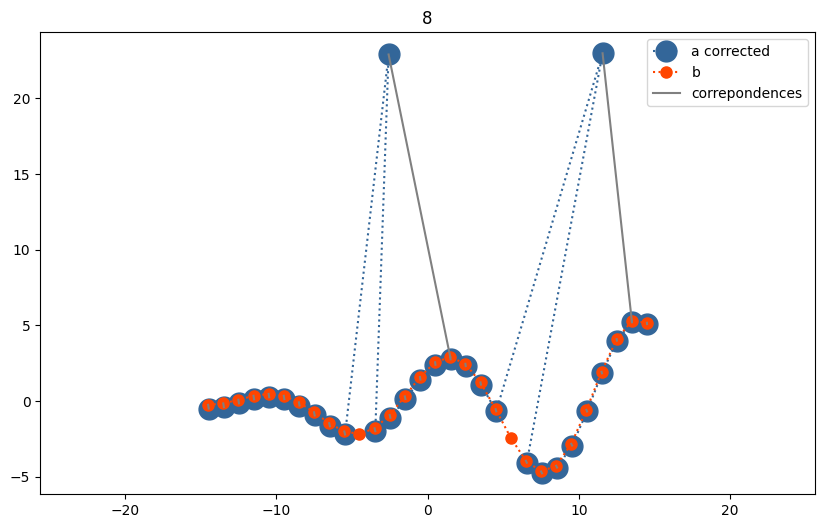

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 9 ||a_centered - b_centered||: 36.27456517027614
Iteration 9 ||I-R||: 0.0007067169359771237 ||t||: 0.007247081499043364 sum: 0.007953798435020488


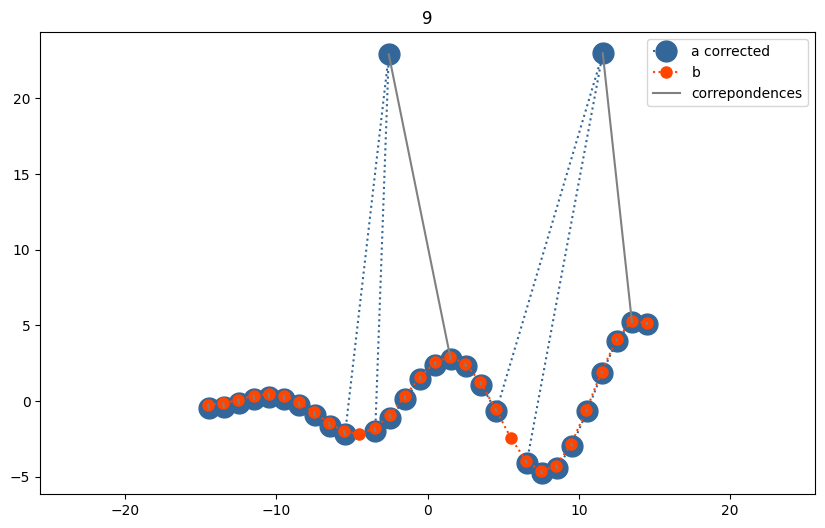

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 10 ||a_centered - b_centered||: 36.27377404344153
Iteration 10 ||I-R||: 0.0006352923084096361 ||t||: 0.006514652331622089 sum: 0.007149944640031726


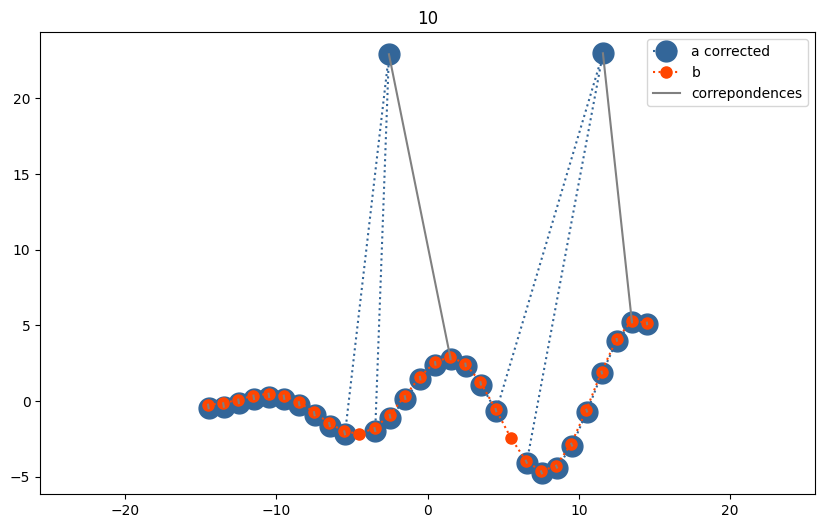

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 11 ||a_centered - b_centered||: 36.27307661950666
Iteration 11 ||I-R||: 0.0005709215798174687 ||t||: 0.005854557897044205 sum: 0.006425479476861674


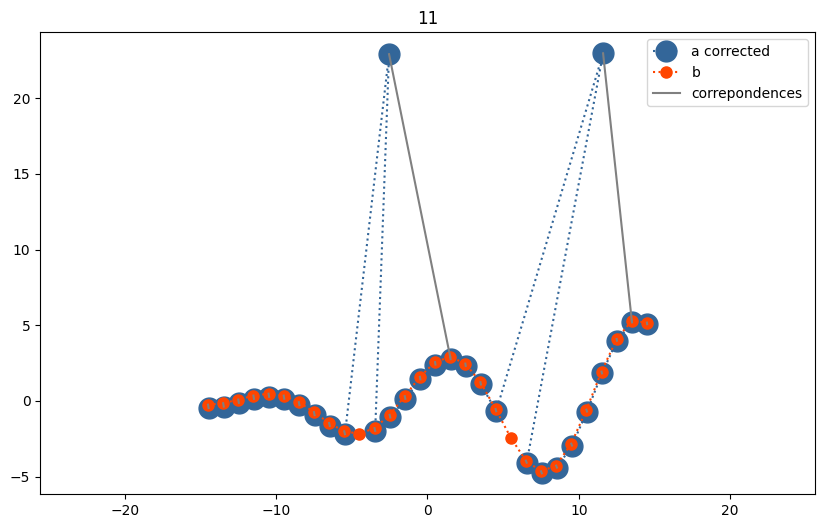

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 12 ||a_centered - b_centered||: 36.27246096681417
Iteration 12 ||I-R||: 0.0005131566137355356 ||t||: 0.005262202746525204 sum: 0.0057753593602607395


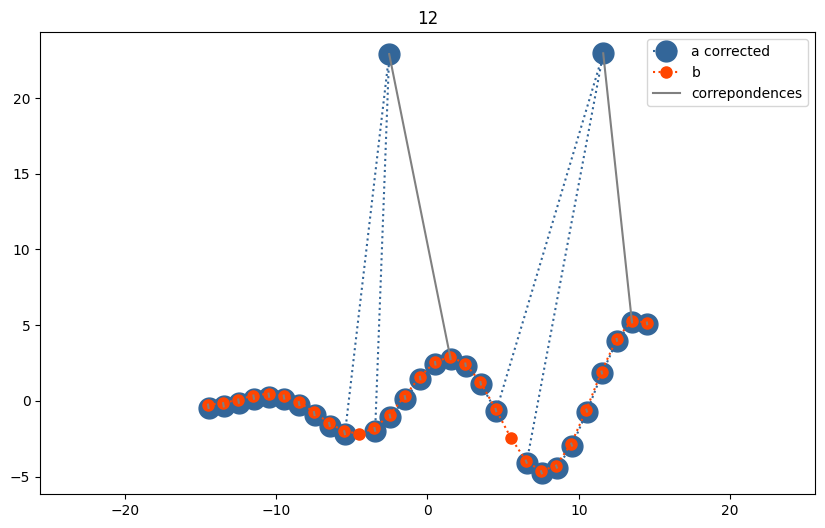

  0%|          | 0/30 [00:00<?, ?it/s]

[10, 20]
Iteration 13 ||a_centered - b_centered||: 36.27191657624124
Iteration 13 ||I-R||: 0.0004614442339331508 ||t||: 0.004731914293172427 sum: 0.005193358527105577


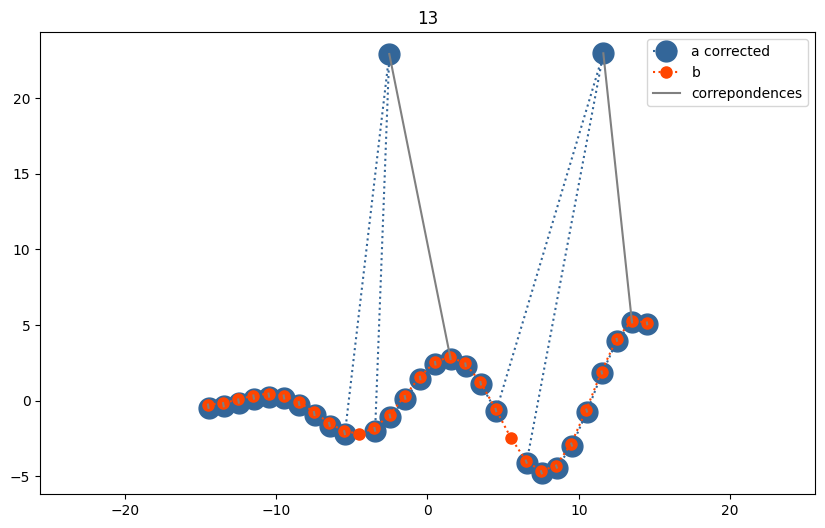

time: 2.56 s (started: 2024-11-15 17:33:22 -03:00)


In [28]:
######### Make next iterations
for iteration in range(1,14):
  # shift point clouds to its centroid
  reduced_a = np.delete(a_corrected, exclude_a_indices, axis=1)
  a_center = reduced_a.mean(axis=1).reshape((b.shape[0],1))
  a_centered = a_corrected - a_center
  # compute correspondeces with nearest neighboor
  correspondences = nearest_neighbor(a_centered, b_centered)
  # compute cross covariance matrix
  exclude_a_indices = []          # <<<<------------- for removing outliers
  exclude_b_indices = []
  H = np.zeros((b.shape[0],b.shape[0]))
  for k, (i, j, d) in enumerate(correspondences):
    a_point = a_centered[:, [i]]
    b_point = b_centered[:, [j]]
    weight =  1/d                 # <<<<------------- for removing outliers
    if weight < threshold:        # <<<<------------- for removing outliers
      weight = 0                  # <<<<------------- for removing outliers
      exclude_a_indices.append(i) # <<<<------------- for removing outliers
      exclude_b_indices.append(j)
    H += weight * b_point.dot(a_point.T)
  print(exclude_a_indices)
  # SVD decomposition
  U, S, V_T = np.linalg.svd(H)
  R_found = U.dot(V_T)
  t_found = b_center - R_found.dot(a_center)
  # stack transformations
  R = R_found.dot(R)
  t = t+t_found
  # Apply correction
  a_corrected = R_found.dot(a_corrected) + t_found
  # or
  # a_corrected = R.dot(a) + t
  # get last erros
  error = np.linalg.norm(a_centered - b_centered)
  print(f"Iteration {iteration} ||a_centered - b_centered||: {error}")
  errors.append(error)

  I_R_norm = np.linalg.norm(np.eye(b.shape[0])-R_found)
  t_norm = np.linalg.norm(t_found)
  error = I_R_norm + t_norm
  print(f"Iteration {iteration} ||I-R||: {I_R_norm} ||t||: {t_norm} sum: {error}")
  errors2.append(error)

  ax = plot_data(a_centered, b_centered, label_1='a corrected', label_2='b',markersize_1=15,title=f"{iteration}")
  draw_correspondeces(a_centered, b_centered, correspondences, ax)
  plt.show()

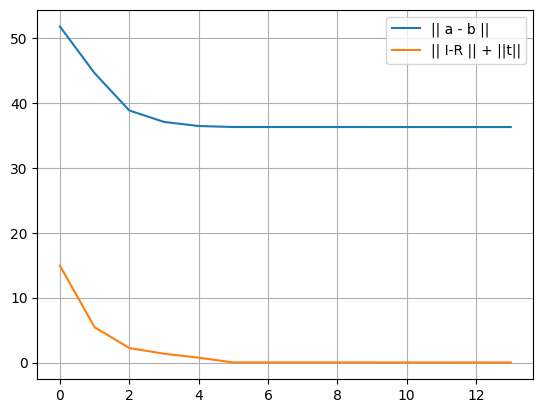

time: 94 ms (started: 2024-11-15 17:33:44 -03:00)


In [29]:
plt.plot(errors, label="|| a - b ||")
plt.plot(errors2, label="|| I-R || + ||t||")
plt.legend()
plt.grid(True)
plt.show()

## Moderate dataset

### Imports

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation


### Functions

time: 0 ns (started: 2024-11-15 18:38:25 -03:00)


### Open Dataset

In [21]:
df = pd.read_csv("./sample_data/t_x_y_z (1).csv", names=["time","x","y","z"], header=None)
df.tail(5)

,time,x,y,z
404522,1.731692e+09,1.495325,0.230588,0.0
404523,1.731692e+09,1.505335,0.217730,0.0
404524,1.731692e+09,1.514246,0.204558,0.0
404525,1.731692e+09,1.524031,0.191375,0.0
404526,1.731692e+09,1.533703,0.178024,0.0


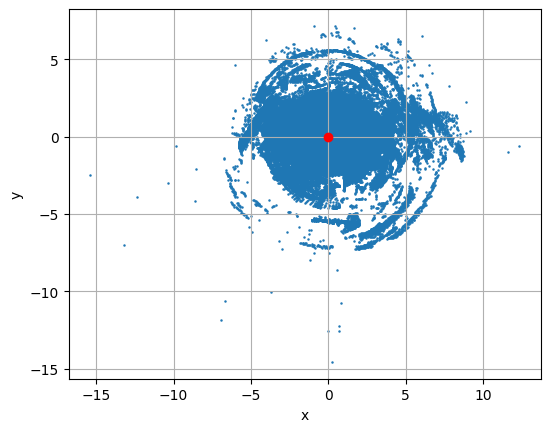

In [22]:
# Create scatter plot
ax = df.plot.scatter(x='x', y='y',s=0.6)
ax.plot(0, 0, 'ro')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

Notice that we have moved the LiDAR origin over a place, we have to separate in $n$ blocks of different Pointclouds in order to apply ICP to join them.

Since this Lidar has 6Hz, one complete rotation was done in:

$$
6 = \frac{1}{t} \rightarrow t = 0.166s
$$

Also notice that LD14P timestamps are 2 bytes, in milliseconds, up to 30000, reseting upon reaching 30000. This means at each 30 seconds we have a timestamp jump in ROS output like the one below:

```
1727627145.1440642, 0.4948835670948028, 0.04581789299845695, 0.0
1727627145.1443145, 0.4982807338237762, 0.04142821952700615, 0.0
1727628224.8594053, 0.8731552362442017, 0.08203010261058807, 0.0
1727628224.8596554, 0.8788626194000244, 0.07432744652032852, 0.0
```

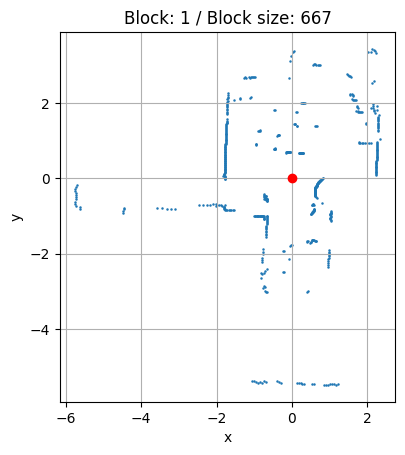

In [23]:
# plot 1st block
i=1
start_time = df.time.values[0]
low_limit = (i-1)*0.1666+start_time
high_limit = i*0.1666+start_time
df2 = df[(df['time']>low_limit) & (df['time']<high_limit)]
block_size = len(df2) + 1
ax = df2.plot.scatter(x='x', y='y',s=0.6)
ax.plot(0, 0, 'ro')
plt.title(f"Block: {i} / Block size: {block_size}")
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

In [24]:
# n = How many blocks of block_size fits on the dataset?
n = int(df.index.values[-1]/block_size)
n

606

In [25]:
## Now, get blocks by block_size
# Split the DataFrame into blocks
dfs = [df.iloc[i*block_size:(i+1)*block_size] for i in range(len(df)//block_size)]

# Initialize the figure and axis
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=0.6)
ax.plot(0, 0, 'ro')
ax.set_ylim(-8, 8)
ax.set_xlim(-8, 8)
ax.set_aspect('equal')
ax.grid(True)
title = ax.set_title("")

# Update function for animation
def update(frame):
    df2 = dfs[frame]
    scatter.set_offsets(df2[['x', 'y']].values)  # Update scatter points
    title.set_text(f"{frame + 1} - ({len(df2)})")  # Update title
    return scatter, title

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(dfs), blit=False, repeat=False
)

# Save the animation as MP4
ani.save('imgs/scatter_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.close(fig)
    

In [29]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('imgs/scatter_animation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video controls  height="500" >
      <source src="%s" type="video/mp4">
</video>
""" % data_url)